# Photoutils tutorial Continued
### (focusing on Aperture and Point Source Photometry)

`aperture_photometry()` function and `ApertureStats` class are the main tools to perform photometry

In [184]:
import numpy as np
import matplotlib.pyplot as plt

from photutils.aperture import (CircularAperture, SkyCircularAperture,
                                aperture_photometry, CircularAnnulus,
                                CircularAperture)
from photutils.datasets import make_wcs, make_noise_image
from photutils.psf import (CircularGaussianPRF, make_psf_model_image,
                            PSFPhotometry)
from photutils.detection import DAOStarFinder

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.nddata import NDData, StdDevUncertainty
from astropy.visualization import simple_norm

## Creating Aperture Objects

In [124]:
# define 2 circular apertures 
positions = [(30.0, 30.0), (40.0, 40.0)]
aperture = CircularAperture(positions, r=3.0) 

In [126]:
# Create aperture object in sky coordinates
positions = SkyCoord(l=[1.2, 2.3]*u.deg, b=[0.1, 0.2]*u.deg,
                    frame='galactic')
aperture = SkyCircularAperture(positions, r=4.0*u.arcsec)

### Converting between Pixel and Sky Apertures


In [128]:
# Convert from Pixel to Sky coordinates
wcs = make_wcs((100, 100))
aperture = CircularAperture((10, 20), r=4.0)
sky_aperture = aperture.to_sky(wcs)
sky_aperture

<SkyCircularAperture(<SkyCoord (ICRS): (ra, dec) in deg
    (197.89234399, -1.36689653)>, r=0.39999999981914736 arcsec)>

In [135]:
# Convert from Sky coordinates to Pixel
position = SkyCoord(197.893, -1.366, unit='deg', frame='icrs')
aperture = SkyCircularAperture(position, r=0.4*u.arcsec)
pix_aperture = aperture.to_pixel(wcs)
pix_aperture

<CircularAperture([26.14628817, 56.58410628], r=4.000000000439744)>

### Performing Aperture Photometry

In [143]:
positions = [(30.0, 30.0), (40.0, 40.0)]
aperture = CircularAperture(positions, r=3.0)

# aperture_photometry assumes that the input data has been
# background subtracted
data = np.ones((100, 100))
phot_table = aperture_photometry(data, aperture)
phot_table['aperture_sum'].info.format = '%.8g'
print(phot_table)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1    30.0    30.0    28.274334
  2    40.0    40.0    28.274334


In [145]:
# Since all the data values are 1.0, the aperture sums are equal
# to the area of a circle with radius = 3
print(np.pi * 3.0 **2)

28.274333882308138


## Aperture and Pixel Overlap

In [146]:
phot_table = aperture_photometry(data, aperture, method='subpixel',
                                 subpixels=5)
print(phot_table)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1    30.0    30.0        27.96
  2    40.0    40.0        27.96


## Aperture Photometry with Multiple Apertures at Each Position

In [147]:
radii = [3.0, 4.0, 5.0]
apertures = [CircularAperture(positions, r=r) for r in radii]
phot_table = aperture_photometry(data, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
    print(phot_table)

 id xcenter ycenter   aperture_sum_0     aperture_sum_1    aperture_sum_2 
      pix     pix                                                         
--- ------- ------- ------------------ ----------------- -----------------
  1    30.0    30.0 28.274333882308134 50.26548245743669 78.53981633974485
  2    40.0    40.0 28.274333882308134 50.26548245743669 78.53981633974485
 id xcenter ycenter   aperture_sum_0     aperture_sum_1    aperture_sum_2 
      pix     pix                                                         
--- ------- ------- ------------------ ----------------- -----------------
  1      30    30.0 28.274333882308134 50.26548245743669 78.53981633974485
  2      40    40.0 28.274333882308134 50.26548245743669 78.53981633974485
 id xcenter ycenter   aperture_sum_0     aperture_sum_1    aperture_sum_2 
      pix     pix                                                         
--- ------- ------- ------------------ ----------------- -----------------
  1      30      30 28.27

## Local Background Subtraction

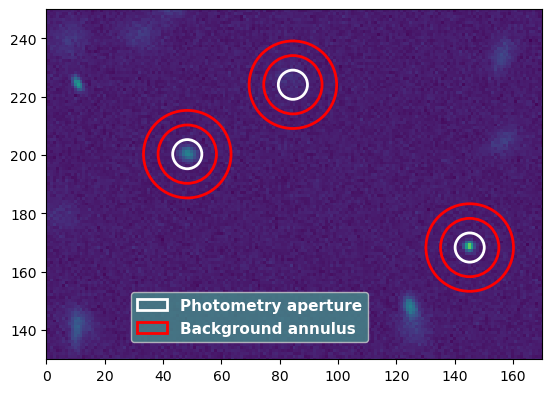

In [168]:
data = make_100gaussians_image()
positions = [(145.1, 168.3), (84.5, 224.1), (48.3, 200.3)]
aperture = CircularAperture(positions, r=5)
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, interpolation='nearest')
plt.xlim(0, 170)
plt.ylim(130, 250)

ap_patches = aperture.plot(color='white', lw=2,
                          label='Photometry aperture')
ann_patches = annulus_aperture.plot(color='red', lw=2,
                                   label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size':11})

## Aperture Masks

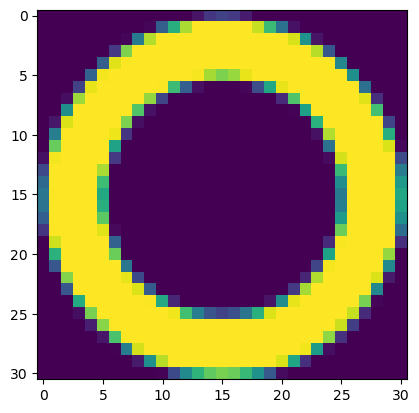

In [169]:
data = make_100gaussians_image()
positions = [(145.1, 168.3), (84.5, 224.1), (48.3, 200.3)]
aperture = CircularAnnulus(positions, r_in=10, r_out=15)

masks = aperture.to_mask(method='exact')

plt.imshow(masks[0])

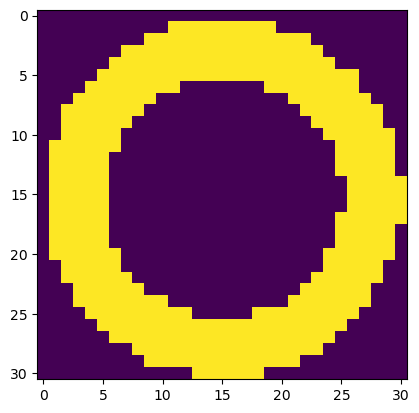

In [171]:
masks2 = aperture.to_mask(method='center')
plt.imshow(masks2[0])

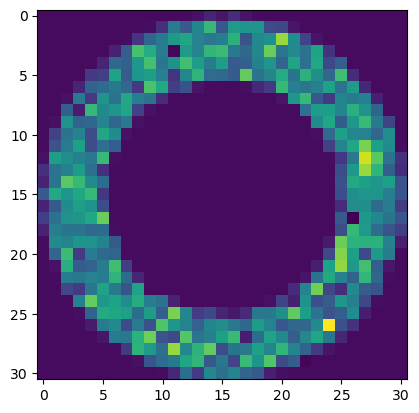

In [172]:
data_weighted = masks[0].multiply(data)
plt.imshow(data_weighted)

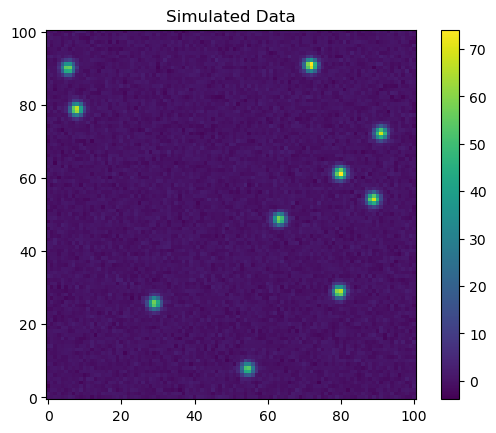

In [175]:
psf_model = CircularGaussianPRF(flux=1, fwhm=2.7)
psf_shape = (9, 9)
n_sources = 10
shape = (101, 101)
data, true_params = make_psf_model_image (shape, psf_model, n_sources,
                                         model_shape=psf_shape,
                                         flux=(500, 700),
                                         min_separation=10, seed=0)
noise = make_noise_image(data.shape, mean=0, stddev=1, seed=0)
data += noise
error = np.abs(noise)

plt.imshow(data, origin='lower')
plt.title('Simulated Data')
plt.colorbar()

## Fitting Multiple Stars

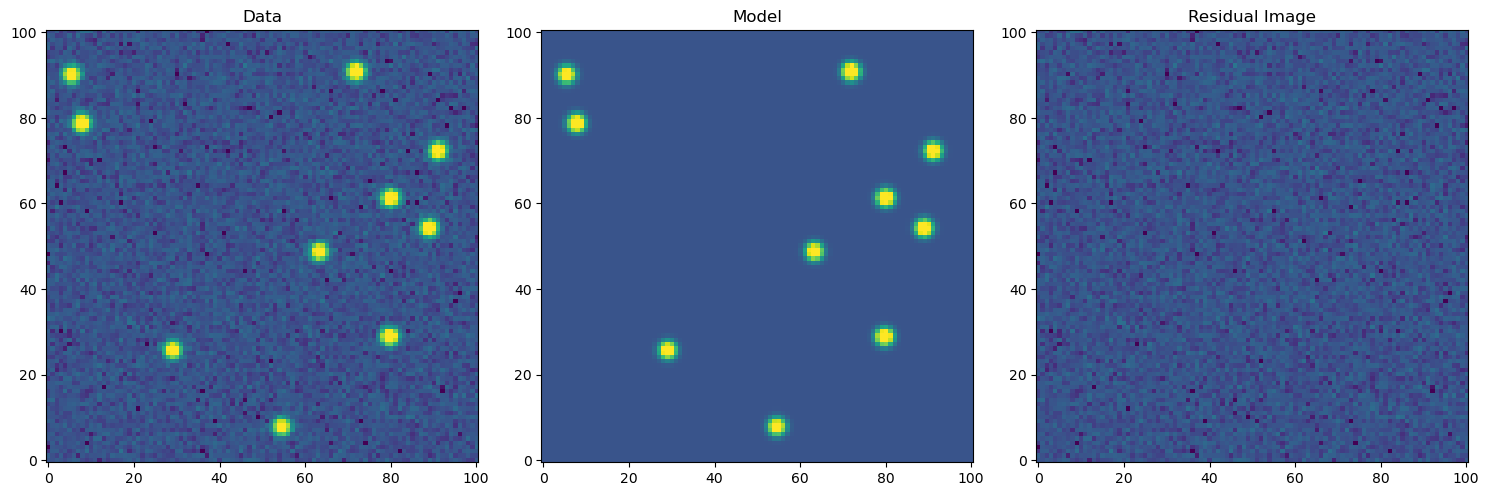

In [185]:
psf_model = CircularGaussianPRF(flux=1, fwhm=2.7)
fit_shape = (5, 5)
finder = DAOStarFinder(threshold=6.0, fwhm=2.0)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,
                       aperture_radius=4)
phot = psfphot(data, error=error)

data, true_params = make_psf_model_image(shape, psf_model, n_sources,
                                         model_shape=psf_shape,
                                         flux=(500, 700),
                                         min_separation=10, seed=0)
noise = make_noise_image(data.shape, mean=0, stddev=1, seed=0)
data += noise
error = np.abs(noise)

psf_model = CircularGaussianPRF(flux=1, fwhm=2.7)
fit_shape = (5, 5)
finder = DAOStarFinder(6.0, 2.0)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,
                        aperture_radius=4)
phot = psfphot(data, error=error)

resid = psfphot.make_residual_image(data)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
norm = simple_norm(data, 'sqrt', percent=99)
ax[0].imshow(data, origin='lower', norm=norm)
ax[1].imshow(data - resid, origin='lower', norm=norm)
im = ax[2].imshow(resid, origin='lower', norm=norm)
ax[0].set_title('Data')
ax[1].set_title('Model')
ax[2].set_title('Residual Image')
plt.tight_layout()

## Source Grouping Algorithms
In PSF photometry, the PSF model fit for a given star can be affected by the presence of the profile of neighboring stars. We can use grouping algorithms to combine neighboring stars into groups that can be fit simultaneously. 

Goal: Separate stars into groups so that the profile of each star in the group does not extend into the fitting region of a star in another group. 

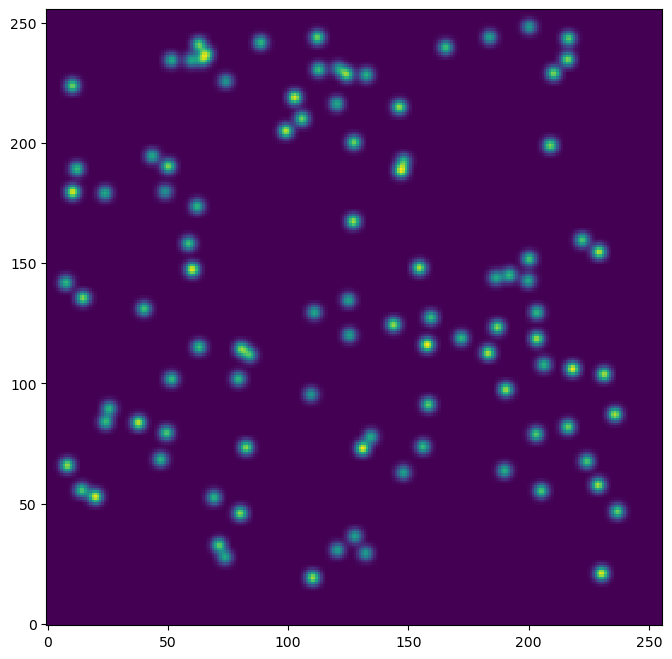

In [186]:
# create a simulated image containing 2D Gaussian sources
shape = (256, 256)
fwhm = 4.7
psf_model = CircularGaussianPRF(fwhm=fwhm)
psf_shape = (11, 11)
n_sources = 100
flux = (500, 1000)
border_size = (7, 7)
data, stars = make_psf_model_image(shape, psf_model, n_sources,
                                  model_shape=psf_shape,
                                  flux=flux,
                                  border_size=border_size, seed=123)

plt.figure(figsize=(8, 8))
plt.imshow(data, origin='lower', interpolation='nearest')